# hw8
---
Here we'd like to use a quantum simulator to illustrate that how one could use qubits to check if his communication to others is secure or not. In other words, one could find out if someone else has already intercepted the information before it passing to him.


In [74]:
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit import BasicAer, execute
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

We assume Alice needs to send a message to Bob and the qubit is at $ |+\rangle $ in X basis. Then if Bob measures it also in X basis, he will get zero.

In [9]:
# define a quantum circuit
q = QuantumCircuit(QuantumRegister(1),ClassicalRegister(1))

# Alice sends the message 
q.h(0)
q.barrier()

# Bob receives and measures it
q.h(0)
q.measure(0,0)

# Draw the circuit
display(q.draw())


┌───┐ ░ ┌───┐┌─┐
q25_0: ┤ H ├─░─┤ H ├┤M├
       └───┘ ░ └───┘└╥┘
 c4: 1/══════════════╩═
                     0

To testify the result, we use Aer simulator in qiskit to simulate the case.


Total count for 0 and 1 are: {'1': 5019, '0': 4981}


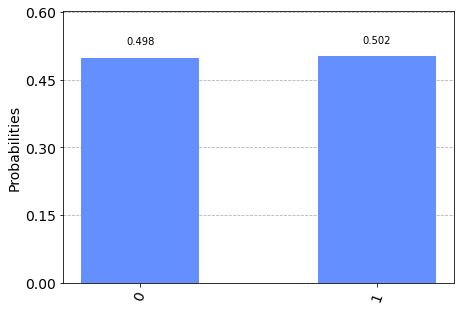

In [83]:
nshots = 10000

# use Aer's simulator to transpile
simulator = QasmSimulator()
compiled_circuit = transpile(q, simulator)
result = simulator.run(compiled_circuit, shots=nshots).result()

# Returns counts
counts = result.get_counts(q)
print("\nTotal count for 0 and 1 are:",counts)
plot_histogram(result.get_counts())


Not surprisingly, Bob always receives a qubit at zero state. However, once a third party Eve trys to eavesdrop such messages, he will measure the qubit before it reaches to Bob, which results in an uncertainty for Bob's measurement result.

In [84]:

# Alice sends the message 
q = QuantumCircuit(QuantumRegister(1),ClassicalRegister(1))
q.h(0)

# Eve measures it and then passes it to Bob
q.measure(0,0)
q.barrier()

# Bob receives and measures it
q.h(0)
q.measure(0,0)

# Draw the circuit
display(q.draw())

┌───┐┌─┐ ░ ┌───┐┌─┐
q293_0: ┤ H ├┤M├─░─┤ H ├┤M├
        └───┘└╥┘ ░ └───┘└╥┘
 c48: 1/══════╩══════════╩═
              0          0


Total count for 0 and 1 are: {'0': 4986, '1': 5014}


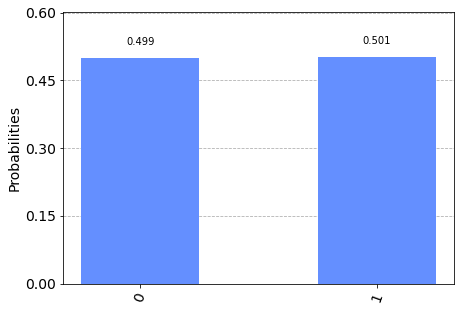

In [85]:
# use Aer's simulator to transpile
simulator = QasmSimulator()
compiled_circuit = transpile(q, simulator)
result = simulator.run(compiled_circuit, shots=nshots).result()

# Returns counts
counts = result.get_counts(q)
print("\nTotal count for 0 and 1 are:",counts)
plot_histogram(result.get_counts())


As we could see, Bob can no longer measure a certain value on X basis but a superposition of states (0.5 of probability for each state). Repeating above processes Bob could find out the conversation is being eavesdropped.

---
This seems a very straightforward example with few gates operation and qubits being used. To further utilize this awesome simulator, we implement it on a quantum teleportation case.  
Let's say, Alice wants to transfer some information to Bob via qubits. Based on [no-cloning theorem](https://en.wikipedia.org/wiki/No-cloning_theorem)  in a quantum system, such tranfering process could be done by a entangled qubit pair and classical bits instead of directly copying the original qubit state. Thus, a third party Eve (friendly in this case) is needed to generate a Bell pair for Bob and Alice.

In [86]:
# create qubits and classical bits
qr = QuantumRegister(3)    
'''
qubit 0 -> the qubit Alice sends to Bob
qubit 1 -> the qubit Alice owns
qubit 1 -> the qubit Bob owns
'''
cr1 = ClassicalRegister(1)
cr2 = ClassicalRegister(1)
qc = QuantumCircuit(qr,cr1,cr2)

# reset all qubits
qc.reset(0)
qc.reset(1)
qc.reset(2)

qc.u(np.pi/2,np.pi/2,np.pi/2,0)
qc.barrier()

# create a bell pair
qc.h(1)
qc.cx(1,2)
qc.barrier()

# prepare the qubit Alice sends to Bob
qc.cx(0,1)
qc.h(0)
qc.barrier()

# store measurements info into classical bits
qc.measure(0,0)
qc.measure(1,1)

# operate the qubic Bob owns based on classical bits
qc.x(2).c_if(cr2,1)
qc.z(2).c_if(cr1,1)
qc.measure(2,0)

qc.draw()

┌────────────────┐ ░            ░      ┌───┐ ░ ┌─┐          »
q305_0: ─|0>─┤ U(π/2,π/2,π/2) ├─░────────────░───■──┤ H ├─░─┤M├──────────»
             └────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐       »
q305_1: ─|0>────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├───────»
                                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐ »
q305_2: ─|0>────────────────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├─»
                                ░      └───┘ ░            ░  ║  ║  └─╥─┘ »
 c49: 1/═════════════════════════════════════════════════════╩══╬════╬═══»
                                                             0  ║ ┌──╨──┐»
 c50: 1/════════════════════════════════════════════════════════╩═╡ = 1 ╞»
                                                                0 └─────┘»
«                  
«q305_0: ──────────
«                  
«q305_1: ──────────
«         ┌───┐ ┌─┐
«q305_2: ─┤ Z ├─┤M├
«         └─╥─┘ └╥┘
«        ┌──╨──┐ ║ 
« c49: 1/╡ = 1 ╞═╩═
«        └─────┘ 0 
« c50: 1/══════════
«


Total count for 0 and 1 are: {'1 1': 2507, '0 1': 2463, '1 0': 2569, '0 0': 2461}


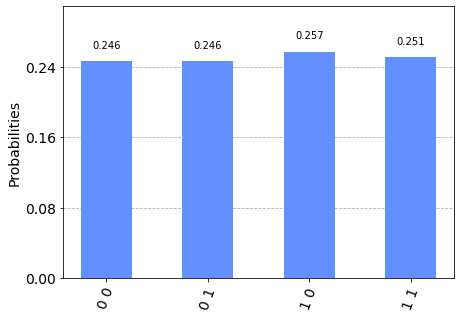

In [87]:
# use Aer's simulator to transpile
compiled_telecircuit = transpile(qc, simulator)
tele_result = simulator.run(compiled_telecircuit, shots=nshots).result()

# Returns counts
tele_counts = tele_result.get_counts(qc)
print("\nTotal count for 0 and 1 are:",tele_counts)
plot_histogram(tele_result.get_counts())

---
We can also operate such experiments/ simulations on real quantum device, with the help of [IBM quantum computer](https://quantum-computing.ibm.com/composer), all above operations could be done on real qubits.

![](qkd1.png)
  
Qubit state received by Bob